In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

# US state names and abbreviations
df_states= pd.read_csv('data/state_table.csv')
df_states = df_states[['name','abbreviation']]
df_states.columns = ['state', 'State']
# df_states[:3]

## get the solar data in a usable form
df_solar = pd.read_csv('data/SolarSummaries.csv')
df_sun = df_solar[['ZIP', 'State','Annual Average Minimum (kWh/m2/day)']]
df_sun.columns = ['ZIP','State','Sun']
df_sun['ZIP'] = df_sun['ZIP'].apply(lambda x: str(x).zfill(5))
# df_sun[:3]

df_census = pd.read_csv('data/ACS_13_5YR_DP04_with_ann.csv',skiprows=1,low_memory = False)
df_housing = df_census[['Id2','Estimate; UNITS IN STRUCTURE - Total housing units - 1-unit, detached']]
df_housing.columns = ['ZIP','Houses']
df_housing['ZIP'] = df_housing['ZIP'].apply(lambda x: str(x).zfill(5))
# df_housing[:3]

df_byzip = df_sun.merge(df_housing)
# df_byzip[:3]

# capacity is in megawatts
df_capacity = pd.read_csv('data/state_capacity_80pct_RE_ETI.csv')
df_capacity = df_capacity.merge(df_states)[['State','year','rooftop_pv']]
df_capacity['num_systems'] = df_capacity['rooftop_pv']*1e3/5 # systems, using an average system size
# df_capacity[:3]
# df_capacity[df_capacity.year == 2050][df_capacity.State == "AL"]

# create a dictionary: number of houses per state
#print 'number of houses in Alaska: ' + str(df_byzip[df_byzip.State == 'AL']['Houses'].sum())
houses_state = {}
list_states = df_byzip.State.drop_duplicates().tolist()
for state in list_states:
    houses_state[state] = df_byzip[df_byzip.State == state]['Houses'].sum()
#houses_state.items()[:5]

In [11]:
# create dictionary: fraction of houses with solar, by state

# growth factor between now and target year
#growth_factor=1.00 # 1.00 = no growth
#target_year=2010

for year in range(2010,2052,2):
    target_year=year

    # fraction of houses with solar, on a state basis
    df_capacity['num_houses'] = df_capacity['State'].apply(lambda x: houses_state[x]*growth_factor)
    df_capacity['solar_fraction'] = df_capacity['num_systems'] / df_capacity['num_houses']
    df_capacity[df_capacity.State == 'CA'][df_capacity.year == target_year][:5]

    # THIS WORKS, USE IT
    # df_capacity[df_capacity.State == 'CA'][df_capacity.year == 2050]['solar_fraction'].iloc[0]

    solarfraction_state = {}
    for state in list_states:
        try: solarfraction_state[state] = df_capacity[df_capacity.State == state][df_capacity.year == target_year]['solar_fraction'].iloc[0]
        except: solarfraction_state[state] = 0

    #solarfraction_state.items()[:5]

    # use the dictionaries to build dataframe with number of houses, solar houses by zip
    df_byzip['Solar Fraction'] = df_byzip['State'].apply(lambda x: solarfraction_state[x])
    df_byzip['Solar Houses'] = (df_byzip['Houses']*df_byzip['Solar Fraction']).round()
    df_byzip[:3]

    # write the dataframe to a file
    df_byzip.to_csv('data/solarhouses_byzip_'+str(target_year)+'.csv')

In [38]:
df_total = []
years = [i for i in range(2010,2052,2)]

for year in years:
    df = pd.read_csv('data/solarhouses_byzip_'+str(year)+'.csv')
    df['Year']=year
    df_total.append(df)

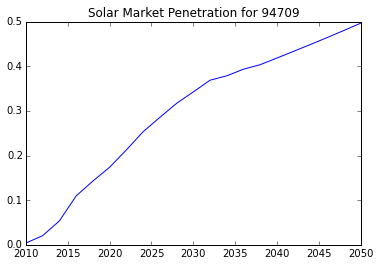

In [42]:
%matplotlib inline
solar_percent = []

##########################
### ENTER YOUR ZIPCODE ###
##########################

my_zip = 94709

for df in df_total:
    solar_percent.append(df[df.ZIP==my_zip]['Solar Fraction'].iloc[0])

plt.plot(years,solar_percent)
plt.title('Solar Market Penetration for ' + str(my_zip))